# Домашнє завдання

В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде класифікувати товари із датасету [fasion_mnist](https://www.tensorflow.org/datasets/catalog/fashion_mnist).


Вам належить запропонувати свою власну архітектуру мережі. Точність найнаївнішої, але адекватної нейромережі становить приблизно 91%. Точність вашої моделі повинна бути не нижчою за цей показник. Щоб досягти таких значень вам знадобиться поекспериментувати з гіперпараметрами мережі:


* кількість шарів;

* кількість нейронів;

* функції активації;

* кількість епох;

* розмір батчу;

* вибір оптимізатора;

* різні техніки регуляризації і т.д.

Використайте вивчені техніки виявлення проблем навчання нейронної мережі, і потім поекспериментуйте.

Рішення оформіть у вигляді окремого ноутбука.

In [88]:
!pip install wandb tensorflow

In [89]:
import os
import math
import random

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix
from tensorflow import keras

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.datasets import imdb
from keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import wandb
from wandb.keras import WandbMetricsLogger

In [90]:
lr = 0.01
n_epochs = 20
batch_size = 256

num_classes = 10

In [91]:
wandb.init(project="Hw9", config={"lr": lr, "n_epochs": n_epochs, "batch_size": batch_size})

In [92]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [93]:
# Перетворення масивів міток з (100000, 1) на (100000,)
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

In [94]:
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape, "y_test shape:", y_test.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)
x_test shape: (10000, 28, 28) y_test shape: (10000,)


In [95]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [96]:
# Оголошуємо вхідний тензор
input_layer = keras.Input(shape=(28, 28, 1))

# Згортковий шар 1
conv1 = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(input_layer)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

# Згортковий шар 2
conv2 = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(pool1)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

# Плоский шар для розгортання в одновимірний вектор
flatten = keras.layers.Flatten()(pool2)

# Повнозв'язний шар 1
dense1 = keras.layers.Dense(256, activation='relu')(flatten)

# Повнозв'язний шар 2
dense2 = keras.layers.Dense(256, activation='relu')(dense1)

# Вихідний шар з 10 нейронами і функцією активації softmax
output_layer = keras.layers.Dense(10, activation='softmax')(dense2)

# Створення моделі
model = keras.Model(inputs=input_layer, outputs=output_layer)

# Виведення інформації про модель
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 3136)              0   

In [97]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [98]:
y_train_encoded = keras.utils.to_categorical(y_train, num_classes)
y_test_encoded = keras.utils.to_categorical(y_test, num_classes)

In [99]:
callback_early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=2,
    verbose=1,
    mode="max",
)

callback_save = ModelCheckpoint(
    "best_Hw9.hdf5",
    monitor="val_loss",
    save_best_only=True,
)

In [100]:
model.fit(x_train,
          y_train_encoded,
          epochs=n_epochs,
          batch_size=batch_size,
          validation_data=(x_test, y_test_encoded),
          verbose=1,
          callbacks=[callback_early_stopping, WandbMetricsLogger(), callback_save])

Epoch 1/20
235/235 [==============================] - 4s 11ms/step - loss: 0.5241 - accuracy: 0.8112 - val_loss: 0.3930 - val_accuracy: 0.8553
Epoch 2/20
235/235 [==============================] - 2s 9ms/step - loss: 0.3184 - accuracy: 0.8854 - val_loss: 0.3046 - val_accuracy: 0.8905
Epoch 3/20
235/235 [==============================] - 2s 8ms/step - loss: 0.2645 - accuracy: 0.9048 - val_loss: 0.2761 - val_accuracy: 0.9051
Epoch 4/20
235/235 [==============================] - 2s 8ms/step - loss: 0.2347 - accuracy: 0.9131 - val_loss: 0.2603 - val_accuracy: 0.9061
Epoch 5/20
235/235 [==============================] - 2s 8ms/step - loss: 0.2121 - accuracy: 0.9222 - val_loss: 0.2497 - val_accuracy: 0.9120
Epoch 6/20
235/235 [==============================] - 2s 8ms/step - loss: 0.1888 - accuracy: 0.9308 - val_loss: 0.2466 - val_accuracy: 0.9120
Epoch 7/20
235/235 [==============================] - 2s 9ms/step - loss: 0.1699 - accuracy: 0.9369 - val_loss: 0.2340 - val_accuracy: 0.9169
Epoch

In [101]:
wandb.finish()

epoch/accuracy,▁▄▅▆▆▆▇▇▇▇███
epoch/epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▂▂▂▂▁▁▁
epoch/val_accuracy,▁▅▆▆▇▇▇████▇█
epoch/val_loss,█▄▃▃▂▂▁▁▂▁▁▃▂
epoch/accuracy,0.9689
epoch/epoch,12
epoch/learning_rate,0.001
epoch/loss,0.08493
epoch/val_accuracy,0.9244


In [102]:
test_loss, test_acc = model.evaluate(x_test, y_test_encoded)

313/313 [==============================] - 1s 3ms/step - loss: 0.2567 - accuracy: 0.9244


In [103]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [104]:
predictions = model.predict(x_test)
predictions[0]

313/313 [==============================] - 1s 2ms/step


array([5.6323756e-07, 9.2343207e-08, 6.1485071e-07, 1.5324438e-06,
       2.7551610e-07, 2.3906228e-05, 3.9347309e-08, 3.4124040e-04,
       1.5113784e-06, 9.9963021e-01], dtype=float32)

In [105]:
predictions.shape

(10000, 10)

In [106]:
np.argmax(predictions[1])

2

In [107]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_names[2]

'Pullover'

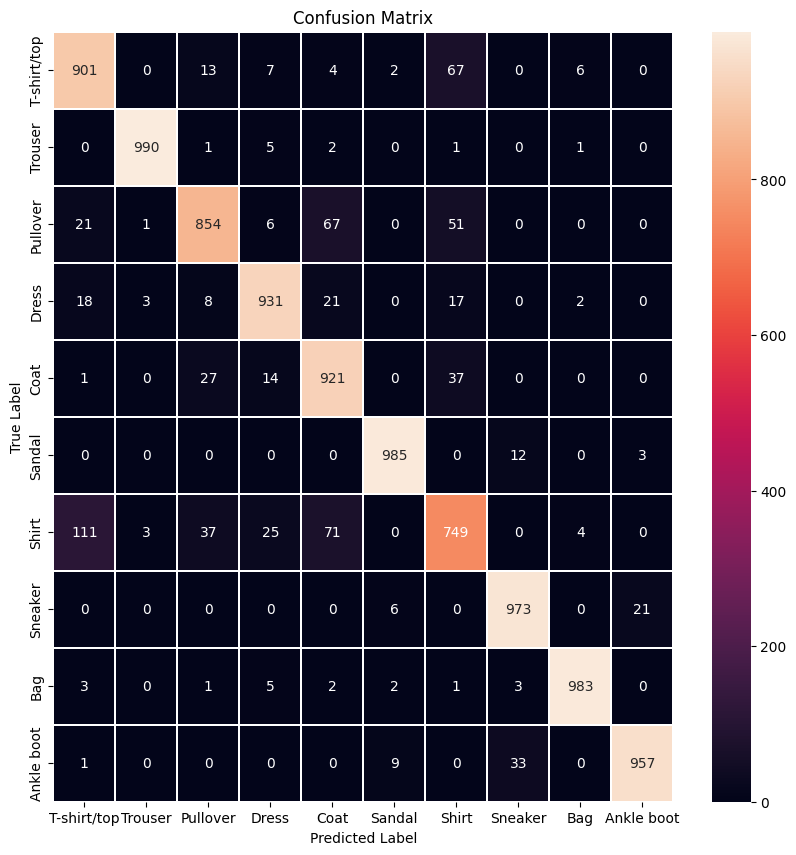

In [108]:
y_pred_classes = np.argmax(predictions, axis = 1)
y_test = y_test.reshape(-1,1)
y_true = np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

f,ax = plt.subplots(figsize = (10,10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, linecolor="white", fmt='.0f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);
plt.show()